# OCR Agent from scratch:

* [Data](./Data-Sources.ipynb)
* [Utilities](./Data-Processing.ipynb)
* [Extract layout features and visual tokens](./Data-Extraction-2.ipynb)
* [Generate training data](./Data-Extraction-3.ipynb)
* [Model architecture](./Model-Training.ipynb)
* Traversal strategies
    * Layout traversal
    * [Text aggregation](./Traversal-Text.ipynb)
    * [Form extraction and validation](./Traversal-Form.ipynb)
* [Reader Agent](./Agent-LM.ipynb)
* [Leverage synthetic training data](./Data-Gen.ipynb)
* [Optimization for production](./Optimization.ipynb)

### Layout reading
Task definition: detect and classify the blocks. Blocks could be nested. The types:
`text`,`table`,`input`,`image`.

Blocks ordering is not important unless the block in focus relays on the information from the other block:
text could get split over the multiple blocks, form inputs and their labels often end up in the separate blocks.
So, we've got the ordering and attribution problems to solve.

We start from some simple heuristics and see how far we can get.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from IPython.display import display, clear_output
from pathlib import Path
from sklearn.neighbors import KDTree
from unidecode import unidecode
from time import sleep

In [2]:
from scripts.extract import *

In [3]:
samples = [str(x)[12:-4] for x in Path('./data/images').glob('*.png')]
len(samples)

8631

In [4]:
source = np.random.choice(samples)

In [5]:
print(source)
image = load_image(source)
#Image.fromarray(image)

irs-f5305c-1


## Common layout types

In [6]:
tokens, words, lines, boxes, success = extract_layout(image)

#### Tabular

In [7]:
def get_tables(cells):
    cols = cells.groupby('top').size()
    rows = cells.groupby('left').size()
    return len(cells), len(cols[cols >= 2]), rows.max()

get_tables(boxes[boxes['type']==CELL])

(3, 0, 3)

#### Multicolumn

In [8]:
def get_columns(lines, width):
    n = len(lines)
    for c in range(2, 4):
        bins = lines['left']//(width//c)
        bins = bins.groupby(bins).size()
        if len(bins) == c and lines['width'].quantile(0.9) < width//c:
            return c
    return None

get_columns(lines, image.shape[1])

2

In [9]:
def default_order(tokens, lines, boxes, width, scale=40):
    num_cells, num_cols, num_rows = get_tables(boxes[boxes['type']==CELL])
    columns = get_columns(lines, width)
    if not columns is None and num_cells < 3 and num_rows < 2:
        print('columns', num_cells, num_cols, num_rows, columns)
        lines['order'] = lines['left']//(width//(columns * 3))
        lines = lines.sort_values(['order','top'])
        return pd.concat([tokens[tokens['line-index']==li] for li in lines.index], ignore_index=True)
    print('standard', num_cells, num_cols, num_rows, columns)
    lines['order'] = lines['top']//scale
    lines = lines.sort_values(['order','left'])
    return pd.concat([tokens[tokens['line-index']==li] for li in lines.index], ignore_index=True)


standard 3 0 3 2


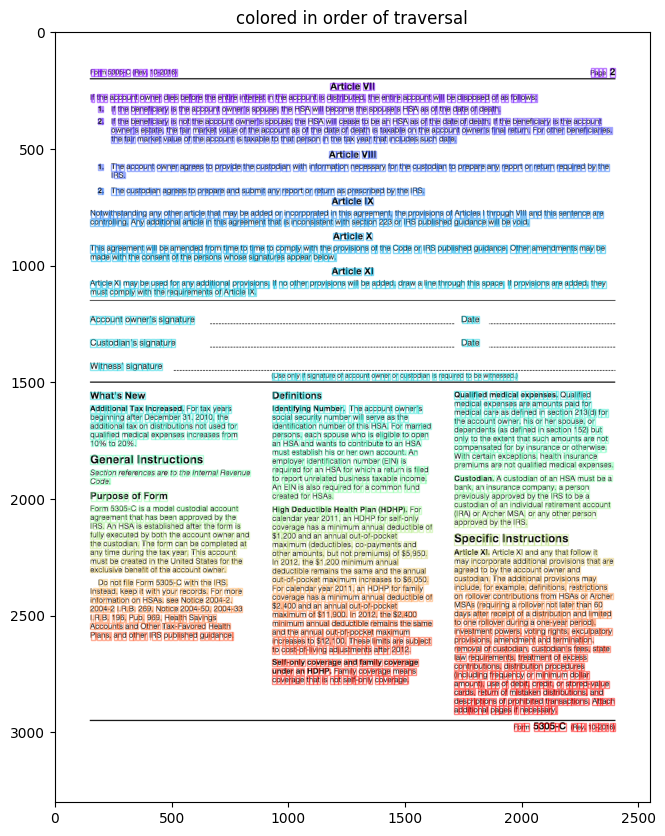

In [10]:
tokens = default_order(tokens, lines, boxes, image.shape[1], scale=40)
    
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, 'gray')
for i, (x, y, w, h) in enumerate(tokens[BOX].values):
    color = plt.cm.rainbow(i/len(tokens))
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none', alpha=0.5))
plt.title(f'colored in order of traversal')
plt.show()

### Aggregation strategies

#### Connected components

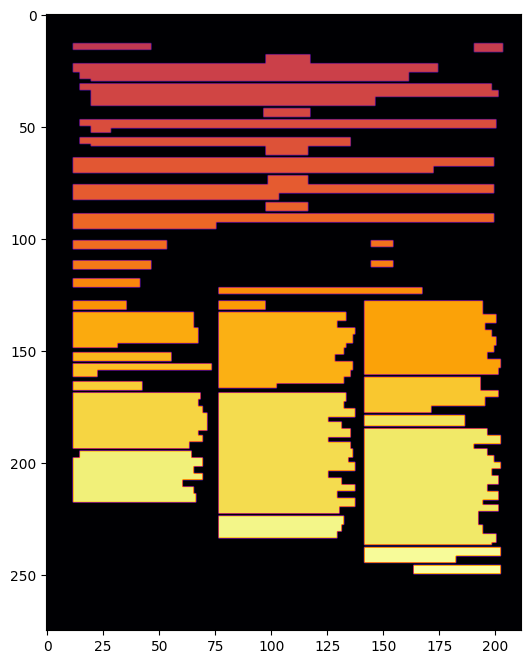

In [11]:
    stats = lines.describe()
    
    def get_text(words, size, bin_size):
        grid = (np.array(words)[:,:4]/bin_size).round().astype(int)
        size = np.array(size)//bin_size
        matrix = np.zeros(size)
        for x, y, w, h in grid:
            matrix[y:y + h + 1,x:x + w + 3] = 1        
        matrix = {(i,j):0 for i,j in np.argwhere(matrix==1)}
        count = 0
        for start in matrix:
            if matrix[start] == 0:
                count += 1
                stack = [start]
                while len(stack) > 0:
                    i,j = stack.pop()
                    matrix[(i,j)] = count
                    stack += [(a,b) for a,b in [(i-1,j),(i,j-1),(i+1,j),(i,j+1)]
                              if (a,b) in matrix and matrix[(a,b)] == 0]
        return matrix

    
    BIN_SIZE = int(stats.loc['min','height']//2)                
    matrix = get_text(words, image.shape, BIN_SIZE)
    
    text_map = np.zeros(np.array(image.shape)//BIN_SIZE)
    N = max(matrix.values())
    indices = list(matrix.keys())
    r, c = zip(*indices)
    text_map[r, c] = (np.array(list(matrix.values())) + N)/N/2
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(text_map, 'inferno')
    plt.show()

### Text aggregation traversal

In [12]:
tokens['index'] = None

tokens.columns

Index(['left', 'top', 'width', 'height', 'block-index', 'line-index',
       'word-index', 'type', 'index'],
      dtype='object')

In [13]:
def run_checkup(tokens, image):
    H, W = image.shape
    result = np.ones((H//4, W//4))
    order = 0
    c = tokens.columns.tolist().index('index')
    for i in range(len(tokens)):        
        x, y, w, h, t = tokens[BOX + ['type']].values[i,:]        
        if t == CHAR:
            if result[y//4 + 1,x//4 + 1] == 0:
                tokens.iloc[i,c] = -1
                continue
            result[y//4:(y + h)//4 + 1,x//4:(x + w)//4 + 1] = 0
        tokens.iloc[i,c] = order
        order += 1
    return result


In [14]:
# check segmentation consistensy and mark potential duplicates
def run_visual_checkup(tokens, image, dim=128, mode='auto'):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    
    H, W = image.shape
    result = np.ones((H//4, W//4))

    order = 0
    c = tokens.columns.tolist().index('index')

    for i in range(len(tokens)):        
        x, y, w, h, t = tokens[BOX + ['type']].values[i,:]
        
        if t == CHAR:
            if result[y//4 + 1,x//4 + 1] == 0:
                tokens.iloc[i,c] = -1
                continue
            result[y//4:(y + h)//4 + 1,x//4:(x + w)//4 + 1] = 0
        tokens.iloc[i,c] = order
        order += 1

        X, Y = max(0, x - dim//2 + w//2), max(0, y - dim//2 + h//2)
        ax.cla()
        ax.imshow(image[Y:Y + dim,X:X + dim], 'gray')
        ax.axvline(x=x + w//2 - X, linestyle=':')
        ax.axhline(y=y + h//2  - Y, linestyle=':')
        ax.set_xticks([i * 25 for i in range(1, dim//25)])
        ax.set_xticklabels([X + i * 25 for i in range(1, dim//25)])
        ax.set_yticks([i * 25 for i in range(1, dim//25)])
        ax.set_yticklabels([Y + i * 25 for i in range(1, dim//25)])
        # make a focus-window
        ax.add_patch(patches.Rectangle((0, 0), x - X, dim,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
        ax.add_patch(patches.Rectangle((x - X + w, 0), dim - x + X - w, dim,
                                       alpha=0.9, edgecolor='none', facecolor='white'))        
        ax.add_patch(patches.Rectangle((x - X, 0), w, y - Y,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
        ax.add_patch(patches.Rectangle((x - X, y - Y + h), w, y - Y,
                                       alpha=0.9, edgecolor='none', facecolor='white'))        
        ax.add_patch(patches.Rectangle((x - X, y - Y), w, h,
                                       linewidth=1, edgecolor='C1', facecolor='none'))
        display(fig)
        clear_output(wait=True)

        if mode == 'manual':
            if input() == '#':
                return
        elif mode == 'slow':
            sleep(0.25)
    return result


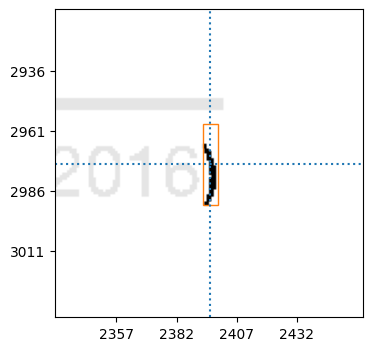

In [15]:
#result = run_checkup(tokens, image)
result = run_visual_checkup(tokens, image)

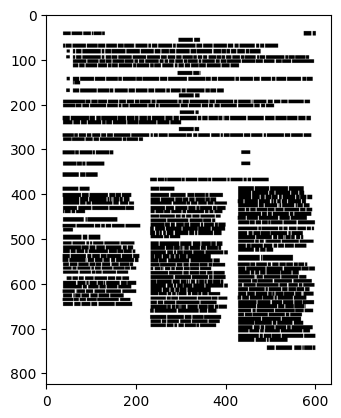

In [16]:
plt.imshow(result, 'gray')
plt.show()

In [17]:
len(tokens[tokens['index']!=-1]), len(tokens)

(4586, 4586)

    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(image, 'gray')
    for x, y, w, h, wi, li, bi, _, _, _ in tokens[tokens['index']!=-1].values:
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none'))
    plt.title('Detected duplicates')
    plt.show()
    
    tokens[tokens['index']==-1]

In [18]:
tokens = tokens.loc[tokens['index']!=-1,:]

stats = tokens.iloc[:,:4].astype(float).describe()
stats.iloc[1:,:].style.background_gradient()

,left,top,width,height
mean,1280.914741,1697.354775,13.433711,30.495639
std,644.387268,791.403814,5.331545,3.040419
min,151.000000,154.000000,1.000000,25.000000
25%,706.250000,950.000000,9.000000,31.000000
50%,1286.000000,1860.000000,15.000000,31.000000
75%,1860.000000,2364.000000,16.000000,31.000000
max,2393.000000,2958.000000,38.000000,49.000000


Takeaway: while text aggregation within the lines is trivial, lines aggregation could be very difficult, some language model is required.